In [0]:
from google.colab import drive
drive.mount('/gdrive')

In [0]:
!cp -f '/gdrive/My Drive/Final Project/images.zip' .
!cp -f '/gdrive/My Drive/Final Project/MoreImages.zip' .
!cp -f '/gdrive/My Drive/Final Project/annotations/captions.json' .
!cp -f '/gdrive/My Drive/Final Project/annotations/labels.json' .
!cp -f '/gdrive/My Drive/Final Project/annotations/images_info.json' .
!cp -f '/gdrive/My Drive/Final Project/annotations/categories_info.json' .
!unzip -q images.zip
!unzip -q MoreImages.zip
!mv -v val2017/* MoreImages/
!mv MoreImages images
!rm -r val2017
!rm -r __MACOSX
!rm images.zip
!rm MoreImages.zip

# Multi-Labale Image Classification
In this part of the project, the problem multi-label image classification is solved. The multi-class scenario, only one label is attributed to the input whilst in multi-label problem, one input may contain several labels. Examples being object detection, multi-texture classification and so on. One way to tackle this problem is to first extract some meaningful features from the input and then pass it to a classifier to classify this input. First approach is to solve many binary classification problem. other approaches like serial classification and more exists but in this part multi binary classification is used. 

An `inception_resnet_v2` network is used for feature extraction. Last feature layer is passed through a global average pooling and then an FC layer with size of 2048 is passed, and then followed by a dropout and a 1024 fully connected layer. Output layer is equal to the number of classes. An Adam optimizer with 0.00001 learning rate is chosen. Loss is set to binary categorical entropy. Measurement of accuracy is done by three parameters. F2-score, Precision, and Recall.

In abstract, ideas used throughout this part of project is:


* Data Augmentaion by rotation zoom, width and height shift and flip.
* Dropour
* Batch Normalization
* Label smoothing
* Early stopping
* He initializer


By freezing the inception network, first the classifier is trained. Then the last layer of the inception network is finetuned. In the next step, 2 last layers of this network is finetuned for a better result.


## Preprocessing
In this part, libraries are imported.

In [0]:
# Basic libraries
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score

# Keras basic libraries
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input
from keras.optimizers import SGD, Adam
from keras import Model

# Pre-trained CNN networks
from keras.applications.vgg19 import VGG19
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import inception_resnet_v2

Using TensorFlow backend.


Parameters are defined here.

In [0]:
# Defining parameters

MAX_NUM_CLASS = 90
BATCH_SIZE = 64
EPOCH_SIZE = 200
INPUT_WIDTH = 299
INPUT_HEIGHT = 299
INPUT_SIZE = ( INPUT_WIDTH, INPUT_HEIGHT )
INPUT_SHAPE = ( INPUT_WIDTH, INPUT_HEIGHT, 3 )

Function are defined in this section.
* json2dict: Extract dictionary from read JSON file
* features2onehot: Encode to one-hot
* onehot2feature: Decode one-hot
* Accuracy parameters: F-beta, Precision, Recall


In [0]:
# Defining our necessary functions

# Function to convert json file into a dictionary
def json2dict( json_file, id_str, category_id, category_2_id = ' ', category_3_id = ' '):
    dict_ = dict()
    for label in json_file:
        if ( label[ id_str ] not in dict_.keys() ):
            dict_[ label[ id_str ] ] = []
        if( label[ category_id ] not in dict_[ label[ id_str ] ] ):
            dict_[ label[ id_str ] ].append( label[ category_id ] )  # Append dictionary enteries
            dict_[ label[ id_str ] ] = list( np.sort( dict_[ label[ id_str ] ] ) )   # Sort dictionary entries
        if( not( category_2_id == ' ' ) ):
            dict_[ label[ id_str ] ].append( label[ category_2_id ] )
        if( not( category_3_id == ' ' ) ):
            dict_[ label[ id_str ] ].append( label[ category_3_id ] )
    return dict_

# Function to encode features into one-hot code
def features2onehot( feature ):
    y = np.zeros( ( MAX_NUM_CLASS ) );
    for i in feature:
        y[ i - 1 ] = 1;
    return y

# Function to decode features from one-hot code
def onehot2features( one_hot ):
    one_hot = np.round( one_hot )
    y = []
    for index, value in enumerate( one_hot ):
        if( value == 1 ):
            y.append( index + 1 )
    return y

# F2-score function for accuracy metric
def fbeta(y_true, y_pred, beta=2):

  y_pred = backend.clip(y_pred, 0, 1)

  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)

  p = tp / (tp + fp + backend.epsilon())
  r = tp / (tp + fn + backend.epsilon())
  
  bb = beta ** 2
  fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
  return fbeta_score

def precision(y_true, y_pred):

  y_pred = backend.clip(y_pred, 0, 1)

  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)

  p = tp / (tp + fp + backend.epsilon())
  
  precision_score = backend.mean(p)
  return precision_score

def recal(y_true, y_pred):

  y_pred = backend.clip(y_pred, 0, 1)

  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)

  r = tp / (tp + fn + backend.epsilon())

  recal_score = backend.mean(r)
  return recal_score

Dictionaries are constructed in this part.

In [0]:
# Loading JSON files
with open('labels.json', 'r') as path:
    json_label = json.load( path )
with open('categories_info.json', 'r') as path:
    json_label_info = json.load( path )
with open('images_info.json', 'r') as path:
    json_image_info = json.load( path )

In [0]:
# Crafting dictionaries from data

dict_label = json2dict( json_label, 'image_id', 'category_id' )
dict_image_info = json2dict( json_image_info, 'id', 'file_name' )
dict_num_2_label = dict()
for label in json_label_info:
    dict_num_2_label[ label[ 'id' ] ] = label[ 'name' ]

print( 'Labels dictionary length: {0}'.format( len( dict_label ) ) )
print( 'Image info dictionary length: {0}'.format( len( dict_image_info ) ) )
print( 'Number of classes: {0}'.format( len( dict_num_2_label ) ) )
print( '\nLabels dictionary: format [image_ID]:[labels]')
print( dict(list(dict_label.items())[0:5]) )
print( '\nImage info dictionary: format [image_ID]:[file_name]')
print( dict(list(dict_image_info.items())[0:3]) )
print( '\nDict2Name dictionary: format [label_number]:[label_describtion]')
print( dict(list(dict_num_2_label.items())) )

Labels dictionary length: 14867
Image info dictionary length: 15000
Number of classes: 80

Labels dictionary: format [image_ID]:[labels]
{289343: [1, 2, 15, 18], 61471: [18, 44, 70], 472375: [4, 18, 47], 520301: [18], 579321: [1, 18]}

Image info dictionary: format [image_ID]:[file_name]
{397133: ['000000397133.jpg'], 37777: ['000000037777.jpg'], 252219: ['000000252219.jpg']}

Dict2Name dictionary: format [label_number]:[label_describtion]
{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboar

Input is read into X and Y,

In [0]:
# Loading images and constructing test and train set

X = []
Y = []
for image_id in dict_image_info:
    if( image_id in dict_label.keys() ):
        X.append( cv2.resize(cv2.imread( './images/' + dict_image_info[ image_id ][0] ),  INPUT_SIZE ) )
        Y.append( features2onehot( dict_label[ image_id ] ) )        

X = np.array( X )
Y = np.array( Y )

print( 'X shape: {}'.format(X.shape) )
print( 'Y shape: {}'.format(Y.shape) )

X shape: (14867, 299, 299, 3)
Y shape: (14867, 90)


Dividing input into train and test set is done in this part. train size is set to 80%.

In [0]:
# Preprocess data and label-smoothing

X_train, X_test, Y_train, Y_test = train_test_split( X, Y, train_size=0.8 )
Y_train = Y_train * 0.8 + 0.1
print( 'Train size: {}'.format(X_train.shape[0]) )
print( 'Test size: {}'.format(X_test.shape[0]) )

Train size: 11893
Test size: 2974


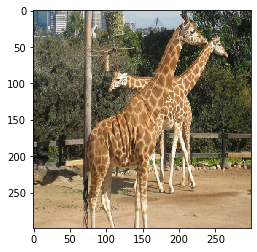

Labels: giraffe.


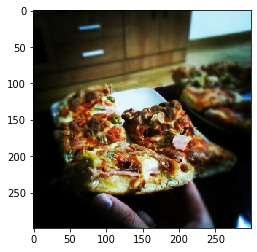

Labels: person, pizza.


In [0]:
# Print some random enteries of the dataset

NUM_OF_SAMPLES = 2
for i in np.random.randint( 0, len(X), NUM_OF_SAMPLES ):
  plt.figure()
  plt.imshow( np.array(X)[i][:,:,::-1] )
  plt.show()
  print( 'Labels:', end= ' ' )
  temp_labels = onehot2features( np.array(Y)[i] )
  for (index, feature) in enumerate( temp_labels ):
    if( not( index == (len(temp_labels) - 1) ) ):
      print( dict_num_2_label[ feature ], end=', ' )
    else:
      print( dict_num_2_label[ feature ], end='.\n' )

Data generator functions are defined in this part.

In [0]:
# Data generator to use in test mode.

def data_generator( X, Y, batch_size ):
  input_ = []
  output = []
  n = 0
  while True:
    for i in range( X.shape[0] ):
      n += 1
      input_.append( inception_resnet_v2.preprocess_input( X[i] ) )
      output.append( Y[i] )
      if( n == batch_size ):
        yield [np.array(input_), np.array(output)]
        input_ = []
        output = []
        n = 0

In [0]:
# Data augmentation to use in train

datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=90, width_shift_range=0.2, height_shift_range=0.2, preprocessing_function=inception_resnet_v2.preprocess_input)
generator = datagen.flow(np.array(X_train), np.array(Y_train), batch_size=BATCH_SIZE, seed=42)

train_result = []
test_result = []

## Define Model
In this part the model is defined. `inception_resnet_v2` is used as the base model without the classifier part. We then define a classifier layer.

In [0]:
# Declaring the base model
model_base = InceptionResNetV2( include_top=False, weights='imagenet', input_shape=INPUT_SHAPE )

# Freez all layers in the base model
for layer in model_base.layers:
  if not("batch" in layer.name):
    layer.trainable = False

Classifier model is defined in the following. A summary is given.

In [0]:
# Defining model artitechture, optimizer, and loss

average_pooling = GlobalAveragePooling2D()(model_base.layers[-1].output)
hidden = Dense(2048, activation='relu', kernel_initializer='he_normal')(average_pooling)
dropout = Dropout(0.25)(hidden)
hidden2 = Dense(1024, activation='relu', kernel_initializer='he_normal')(dropout)
output = Dense(MAX_NUM_CLASS, activation='sigmoid')(hidden2)

model = Model(inputs=model_base.inputs, outputs=output)

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=[fbeta, precision, recal] )

model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
______________________________________________________________________________

Fitting the model using `fit_generator`. Early stopping is also applied. Result in each step is appended to `train_result` and `test_result`.

In [0]:
early_stopping_param = 3
early_stopping_var = 0
early_stopping_counter = 0

for i in range(EPOCH_SIZE):
  print( 'Epoch: {0}'.format(i+1) )
  history = model.fit_generator( generator, steps_per_epoch=len(X_train)/BATCH_SIZE, epochs=1, shuffle=True, verbose=1)
  test_result = model.evaluate_generator( data_generator( X_test, Y_test, 16 ), steps=len(X_test)/16, verbose=0 )
  print( 'Train loss: {0} - Train f2-score, precision, recall: {1}, {2}, {3}'.format( history.history['loss'][0], history.history['fbeta'][0], history.history['precision'][0], history.history['recal'][0] ) )
  print( 'Test loss: {0} - Test f2-score, precision, recall: {1}, {2}, {3}'.format( test_result[0], test_result[1], test_result[2], test_result[3] ) )
  if( i > 0 and early_stopping_var < test_result[0] ):
    early_stopping_counter += 1
  else:
    early_stopping_counter = 0
  if( early_stopping_counter >= early_stopping_param ):
    break
  early_stopping_var = test_result[0]
  train_result.append( history )
  test_result.append( test_result )


Epoch: 1
Epoch 1/1
186/185 [==============================] - 268s 1s/step - loss: 0.3687 - fbeta: 0.2924 - precision: 0.5248 - recal: 0.2756
Train loss: 0.3687138520447428 - Train f2-score, precision, recall: 0.2923636305104651, 0.5247428392447806, 0.2755543100095162
Test loss: 0.3652503855912254 - Test f2-score, precision, recall: 0.5069835104283744, 0.7288443713718881, 0.48761393130827685
Epoch: 2
Epoch 1/1
186/185 [==============================] - 232s 1s/step - loss: 0.3563 - fbeta: 0.4912 - precision: 0.7290 - recal: 0.4709
Train loss: 0.3563037589411654 - Train f2-score, precision, recall: 0.4912707558905498, 0.7289825683434737, 0.470968038740806
Test loss: 0.3581980053177598 - Test f2-score, precision, recall: 0.5686143967069349, 0.7961218876672737, 0.5490461255711201
Epoch: 3
Epoch 1/1
186/185 [==============================] - 231s 1s/step - loss: 0.3537 - fbeta: 0.5580 - precision: 0.7914 - recal: 0.5376
Train loss: 0.3536925928542364 - Train f2-score, precision, recall: 0.

KeyboardInterrupt: ignored

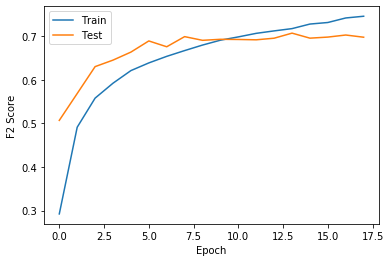

In [0]:
plt.figure()
plt.plot(history['fbeta'])
plt.plot(test_result[:][1])
plt.xlabel('Epoch')
plt.ylabel('F2 Score')
plt.legend(['Train', 'Test'])
plt.show()

In [0]:
# Save model
model.save('/gdrive/My Drive/Final Project/model_classification_15k.h5')

## Train Further
by training the classifier and geeting proper results, we now inted to fine tune last layers of the network in order to extract good features for multi-label classification task. We do this by freezing all but last layer of the inception network and classifier, and then fitting the model.

In [0]:
from keras.models import load_model
dependencies = {
    'fbeta': fbeta, 'precision':precision, 'recal':recal
}
model = load_model('/gdrive/My Drive/Final Project/model_classification_15k.h5', custom_objects=dependencies)
model.summary()

Freez all but the last layer and the classifier of the network.

In [0]:
TRANABLE_LAYER_NUM = 629
for layer in model.layers[TRANABLE_LAYER_NUM:]:
   layer.trainable = True

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[fbeta, precision, recal] )

In [0]:
early_stopping_param = 3
early_stopping_var = 0
early_stopping_counter = 0

train_result = []
test_result = []

for i in range(EPOCH_SIZE):
  print( 'Epoch: {0}'.format(i+1) )
  history = model.fit_generator( generator, steps_per_epoch=len(X_train)/BATCH_SIZE, epochs=1, shuffle=True, verbose=1)
  test_result = model.evaluate_generator( data_generator( X_test, Y_test, 8 ), steps=len(X_test)/8, verbose=1 )
  print( 'Train loss: {0} - Train f2-score: {1}, precision: {2}, recall: {3}'.format( history.history['loss'][0], history.history['fbeta'][0], history.history['precision'][0], history.history['recal'][0] ) )
  print( 'Test loss: {0} - Test f2-score: {1}, precision: {2}, recall: {3}'.format( test_result[0], test_result[1], test_result[2], test_result[3] ) )
  if( i > 0 and early_stopping_var < test_result[0] ):
    early_stopping_counter += 1
  else:
    early_stopping_counter = 0
  if( early_stopping_counter >= early_stopping_param ):
    break
  early_stopping_var = test_result[0]
  train_result.append( history )
  test_result.append( test_result )


Epoch: 1
Epoch 1/1
372/371 [==============================] - 32s 85ms/step
Train loss: 0.027897583990274262 - Train f2-score: 0.8420522145373781, precision: 0.9361230473206441, recall: 0.8332001342010049
Test loss: 0.75830475457253 - Test f2-score: 0.7679531236169159, precision: 0.8699231772653518, recall: 0.7626753205093004
Epoch: 2
Epoch 1/1
372/371 [==============================] - 32s 85ms/step
Train loss: 0.02492579597208289 - Train f2-score: 0.8606053275987036, precision: 0.9432992733207471, recall: 0.8530478013140154
Test loss: 0.8219289689935664 - Test f2-score: 0.7599396360337093, precision: 0.8833194070605821, recall: 0.7510264798678378
Epoch: 3
Epoch 1/1
372/371 [==============================] - 32s 85ms/step
Train loss: 0.022206360793884012 - Train f2-score: 0.8782636741107179, precision: 0.9497706092637852, recall: 0.8714548545038892
Test loss: 0.8736983931833698 - Test f2-score: 0.7531353230437925, precision: 0.8783748558452052, recall: 0.7438088642653599
Epoch: 4
Epoc

KeyboardInterrupt: ignored

In [0]:
model.save('/gdrive/My Drive/Final Project/model_classification_15k_finetune_lastlayer.h5')

## Train further-further ahead
Further, model but two last layer of inception and classifier is freezed and the model is fine-tuned.

In [0]:
from keras.models import load_model
dependencies = {
    'fbeta': fbeta, 'precision':precision, 'recal':recal
}
model = load_model('/gdrive/My Drive/Final Project/model_classification_15k_finetune_lastlayer.h5', custom_objects=dependencies)

In [0]:
TRANABLE_LAYER_NUM = 462
for layer in model.layers[:TRANABLE_LAYER_NUM]:
   layer.trainable = False
for layer in model.layers[TRANABLE_LAYER_NUM:]:
   layer.trainable = True

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=[fbeta, precision, recal] )

In [0]:
early_stopping_param = 3
early_stopping_var = 0
early_stopping_counter = 0
BATCH_SIZE = 16
train_result_ft2 = []
test_result_ft2 = []
for i in range(1):
  print( 'Epoch: {0}'.format(i+1) )
  history = model.fit_generator( generator, steps_per_epoch=len(X_train)/BATCH_SIZE, epochs=1, shuffle=True, verbose=1)
  test_result = model.evaluate_generator( data_generator( X_test, Y_test, 8 ), steps=len(X_test)/8, verbose=1 )
  print( 'Train loss: {0} - Train f2-score: {1}, precision: {2}, recall: {3}'.format( history.history['loss'][0], history.history['fbeta'][0], history.history['precision'][0], history.history['recal'][0] ) )
  print( 'Test loss: {0} - Test f2-score: {1}, precision: {2}, recall: {3}'.format( test_result[0], test_result[1], test_result[2], test_result[3] ) )
  if( i > 0 and early_stopping_var < test_result[0] ):
    early_stopping_counter += 1
  else:
    early_stopping_counter = 0
  if( early_stopping_counter >= early_stopping_param ):
    break
  early_stopping_var = test_result[0]
  train_result_ft2.append( history )
  test_result_ft2.append( test_result )

Epoch: 1
Epoch 1/1
372/371 [==============================] - 37s 100ms/step
Train loss: 0.35242566783512086 - Train f2-score: 0.6420967929446746, precision: 0.8329255287376914, recall: 0.6239075228555604
Test loss: 0.1346308614217466 - Test f2-score: 0.778449454294738, precision: 0.9174578044042793, recall: 0.7644604078383856


In [0]:
model.save('/gdrive/My Drive/Final Project/model_classification_15k_finetune_2lastlayer.h5')

## Evaluating Model
Firs off, some random images from test dataset are chosen and predicted labels are printed. As it can be seen, model does a descent job.

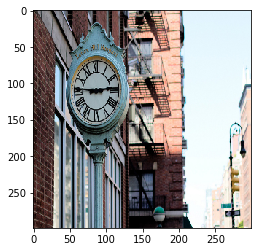

clock


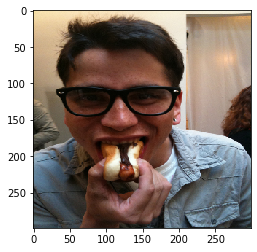

person


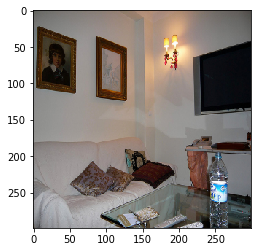

bottle
chair
couch
tv
book


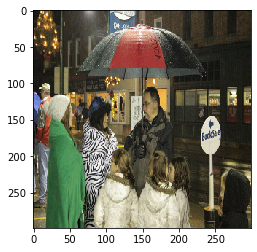

person
umbrella
handbag


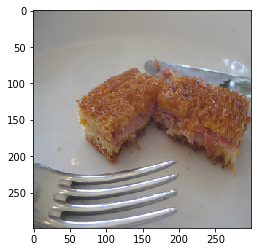

fork
knife


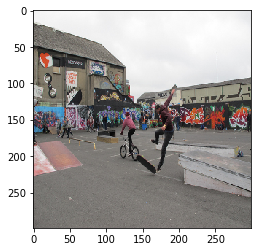

person
bicycle


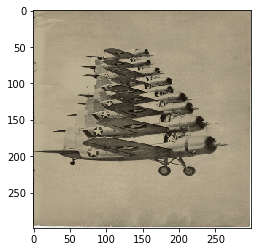

person
airplane


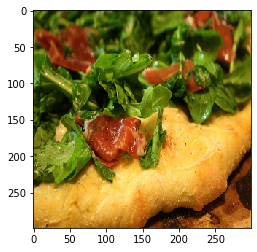

pizza


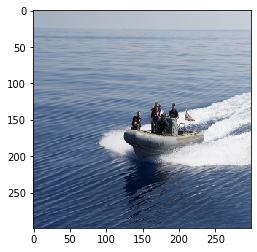

person
boat


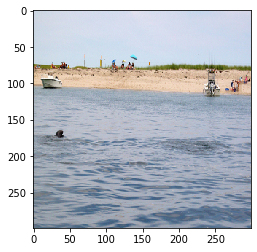

person
boat


In [0]:
for i in np.random.randint(0, len(X_test), 10):
  y_pred = model.predict( np.array( inception_resnet_v2.preprocess_input( np.expand_dims( X_test[i], 0 ) ) ) )
  Y_pred = np.round( y_pred )
  plt.imshow(X_test[i][:,:,::-1])
  plt.show()
  for feature in onehot2features( np.array(Y_pred)[0] ):
    print( dict_num_2_label[ feature ] )

Now some other images (some being taken with my phone) are tested on this model. Results are depicted below.

(299, 299, 3)


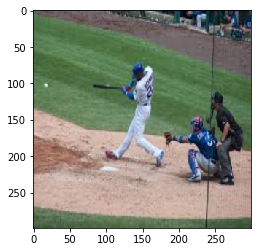

person
sports ball
baseball bat
baseball glove
(299, 299, 3)


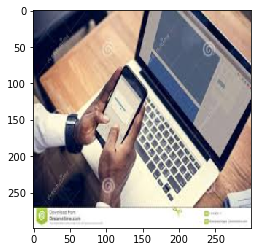

person
laptop
cell phone
(299, 299, 3)


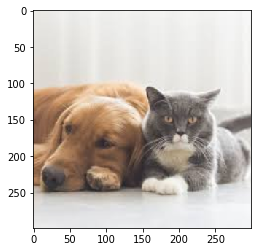

cat
dog
(299, 299, 3)


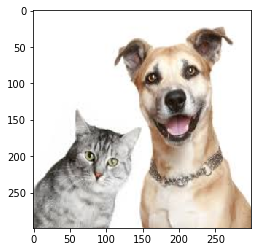

dog
(299, 299, 3)


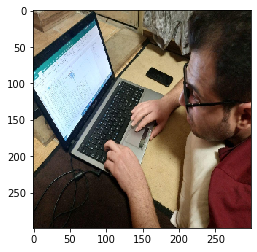

person
laptop
(299, 299, 3)


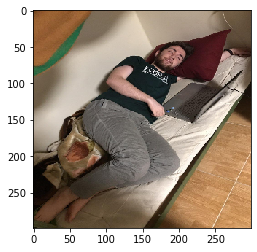

person
bed


In [0]:
image_name = ['index.jfif', 'fd.jfif', 'dogcat2.jfif', 'dogcat3.jfif', 'arash.jpg', 'r.jpg']
for name in image_name:
  u_o =  cv2.resize( cv2.imread( '/gdrive/My Drive/Final Project/Test images/' + name), INPUT_SIZE ) 
  u = inception_resnet_v2.preprocess_input( u_o )
  print( u.shape )
  y_pred = model.predict( np.array( np.expand_dims( u, 0 ) ) )
  Y_pred = np.round( y_pred )
  Y_pred.shape
  plt.imshow(u_o[:,:,::-1])
  plt.show()
  for feature in onehot2features( np.array(Y_pred)[0] ):
    print( dict_num_2_label[ feature ] )